Handle the dependencies for training and plotting purposes

In [26]:
import keras
from keras.layers import (
    Dense,
    Activation,
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    Input,
    Add,
    Reshape
)
from keras.models import (
    Sequential, Model
)
from keras.activations import (
    softmax,
    tanh,
    sigmoid,
    relu
)
from keras import optimizers
import numpy as np
import os
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

Specifies the hyperparameters for trainning  
``Modifies the cell below for tunning the parameters``

In [27]:
INPUT_SHAPE = (128, 128, 3)
BATCH_SIZE = 2
LR = 1e-3
DECAY = .99

# Upsampling parameters
NUM_CONV_LAYERS = 1
INIT_FILTER = 8
KERNEL_SIZE = 3
CONV_STRIDES = (2, 2)

# Residual Block parameters
NUM_REPETITIONS = 2
NUM_RES_BLOCKS = 1
RES_STRIDES = (1, 1)

Defines helper functions

In [64]:
""" Return an activation function as needed"""
def activation_func(name):

    def leakyReLu(input_):
        return relu(input_, alpha=.3)

    return {
            'ReLU': relu,
            'tanh': tanh,
            'leakyReLU': leakyReLu,
            'sigmoid': sigmoid,
            'softmax': softmax
    }[name]

""" 
Plot the images inline using matplotlib.

This function takes in 8 pictures where 

X -> Original Picture X 
Y -> Original Picture Y
Y' -> generator_xy(X)
X' -> generator_yx(Y)
Y'' -> generator_xy(X')
X'' -> generator_yx(Y')
X_identical -> generator_yx(X)
Y_identical -> generator_xy(Y)

"""
def plot_images(*images):
    assert(len(images) == 8)
    plt.tight_layout()
    plt.subplots_adjust(hspace = .5)
    image_names = ['X', 'Y', "Y'", "X'", "X''", "Y''", 'X_identical', 'Y_identical']
    
    for i, name in enumerate(image_names):
        plt.subplot(4, 2, i+1)
        plt.imshow(images[i])
        plt.title(name)
    

In [43]:
class CycleGAN:
    def __init__(self):
        self.generator_xy = self.generator()
        self.generator_yx = self.generator()
        self.discriminator_x = self.discriminator()
        self.discriminator_y = self.discriminator()

        X, Y     = Input(INPUT_SHAPE)   , Input(INPUT_SHAPE)
        X_, Y_   = self.generator_yx(Y) , self.generator_xy(X)
        X__, Y__ = self.generator_yx(Y_), self.generator_xy(X_)
        X_identity, Y_identity = self.generator_yx(X), self.generator_xy(Y)

        adam = optimizers.Adam(lr=LR, decay=DECAY)
 
        self.discriminator_x.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
        self.discriminator_y.compile(loss='mse', optimizer=adam, metrics=['accuracy'])

        self.discriminator_x.trainable = False
        self.discriminator_y.trainable = False

        X_valid, Y_valid = self.discriminator_x(X_), self.discriminator_y(Y_)

        # TODO: Figure out the weights of the losses
        self.generators = Model(inputs=[X, Y], outputs=[X_valid, Y_valid, X_, Y_, X__, Y__, X_identity, Y_identity])
        
        # The paper suggests using L1 norm for the last four loss functions, try out different settings if it doesn't work
        self.generators.compile(
            loss=['mse']*2 + ['mae']*6,
            loss_weights=[1, 1, 0, 0, 10, 10, 1, 1],
            optimizer=adam
        )


    def discriminator(self):
        # Input is an image
        model = Sequential()
        filter_out = self.conv(model, 'leakyReLU')
        # Not sure if a binary discriminator needs residual blocks
        self.residuals(model, 'leakyReLU', filter_out)
        self._addConvBlock(model, 'leakyReLU', filters=1, kernel_size=KERNEL_SIZE, strides=CONV_STRIDES)
        model.add(Reshape((-1,)))
        model.add(Dense(1))

        return model

        
    def generator(self):
        model = Sequential()
        filter_out = self.conv(model, 'leakyReLU')
        self.residuals(model, 'leakyReLU', filter_out)
        self.deconv(model, 'leakyReLU', filter_out)

        return model
        
    # Downsampling - return the final filter size
    def conv(self, model, activations, init_filter=INIT_FILTER, kernel_size=KERNEL_SIZE, strides=CONV_STRIDES):
        self._addConvBlock(model, activations, init_filter, kernel_size, strides, True)

        for i in range(NUM_CONV_LAYERS-1):
            init_filter *= 2
            self._addConvBlock(model, activations, init_filter, kernel_size, strides)

        return init_filter
    
    def deconv(self, model, activations, filters, kernel_size=KERNEL_SIZE, strides=CONV_STRIDES):
        for i in range(NUM_CONV_LAYERS-1):
            filters /= 2
            self._addDeconvBlock(model, activations, filters, kernel_size, strides)

        self._addDeconvBlock(model, activations, INPUT_SHAPE[2], kernel_size, strides)

    def residuals(self, model, activations, filters, kernel_size=KERNEL_SIZE, strides=RES_STRIDES, repetitions=NUM_REPETITIONS):
        for i in range(NUM_RES_BLOCKS):
            self._addResBlock(model, activations, filters, kernel_size, strides, repetitions)

    def _addResBlock(self, model, activations, filters, kernel_size, strides, repetitions):
        for i in range(repetitions):
            self._addConvBlock(model, activations, filters, kernel_size, strides)

    def _addDeconvBlock(self, model, activations, filters, kernel_size=KERNEL_SIZE, strides=CONV_STRIDES):
        model.add(BatchNormalization(axis=3))
        model.add(Activation(activation_func(activations)))
        model.add(Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same'))

    def _addConvBlock(self, model, activations, filters, kernel_size, strides, input_layer=False):
        if not input_layer:
            model.add(BatchNormalization(axis=3))
            model.add(Activation(activation_func(activations)))
            model.add(Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same'))
        else:
            model.add(Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', input_shape=INPUT_SHAPE))

    def train(self, iterator):
        # TODO: implements training process
        valid = np.ones((BATCH_SIZE, 1))
        fake  = np.zeros((BATCH_SIZE, 1))
        for epoch in range(0,100):
            for batch_i, (x_train, y_train) in enumerate(iterator.load_batch(BATCH_SIZE)):
                x_valid, y_valid, x_, y_, x__, y__, x_identity, y_identity = self.generators.predict([x_train, y_train])

                d_x_real_loss = self.discriminator_x.train_on_batch(x_train, valid)
                d_x_fake_loss = self.discriminator_x.train_on_batch(x_valid, fake)
                d_x_loss = 0.5 * np.add(d_x_real_loss, d_x_fake_loss)

                d_y_real_loss = self.discriminator_y.train_on_batch(y_train, valid)
                d_y_fake_loss = self.discriminator_y.train_on_batch(y_valid, fake)
                d_y_loss = 0.5 * np.add(d_y_real_loss, d_y_fake_loss)

                # Total disciminator loss
                d_loss = 0.5 * np.add(d_x_loss, d_y_loss)

                # Total generator loss
                g_loss = self.generators.train_on_batch([x_train, y_train],
                                                            [valid, valid,
                                                            x_train, y_train,
                                                            x_train, y_train])
                
                if batch_i % 100 == 0:
                    plot_images(
                        x_train[0], y_train[0],
                        x_[0], y_[0],
                        x__[0], y__[0],
                        x_identity[0], y_identity[0]
                    )
                    
                    print('Loss of Discriminator X: ', x_valid, 'Loss of Discriminator Y:', y_valid)
                        
                
                    

    def test(self, x_test, y_test):
        # TODO: implements evaluation
        pass

In [44]:
# TODO Preprocess input images
'''
# Preprocess input is done and it works. May need to make it as a function
dirDataset = tf.data.Dataset.list_files('./image/*.jpg')
dirDataset2 = tf.data.Dataset.list_files('./image/*.jpg')

imageDataset = dirDataset.map(lambda x: tf.image.resize_images(tf.image.decode_jpeg(tf.read_file(x), channels = INPUT_SHAPE[2]), [INPUT_SHAPE[0], INPUT_SHAPE[1]]))
imageDataset2 = dirDataset2.map(lambda x: tf.image.resize_images(tf.image.decode_jpeg(tf.read_file(x), channels = INPUT_SHAPE[2]), [INPUT_SHAPE[0], INPUT_SHAPE[1]]))
xyDataset = tf.data.Dataset.zip((imageDataset, imageDataset2))
xyDataset = xyDataset.batch(BATCH_SIZE)

iterator = imageDataset.make_one_shot_iterator()
x_train = iterator.get_next()

Sess = tf.Session()
print(Sess.run(x_train))


'''
x_train = np.random.normal(size=[2560, 128, 128, 3])
# y_train = x_train # train tensor for the generator
y_train = np.random.normal(size=[2560, 1]) # train tensor for the discriminator

x_test = np.random.normal(size=[2560, 128, 128, 3])
# y_test = x_test # test tensor for the generator
y_test = np.random.normal(size=[2560, 1]) # test tensor for the discriminator


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


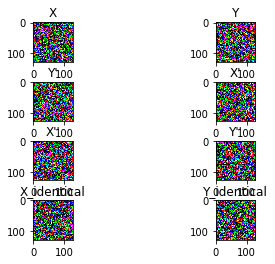

In [65]:
plot_images(
    x_train[0], x_train[1],
    x_train[2], x_train[3],
    x_train[4], x_train[5],
    x_train[6], x_train[7]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1/1
2560/2560 [==============================] - 6s 2ms/step - loss: 1.5407


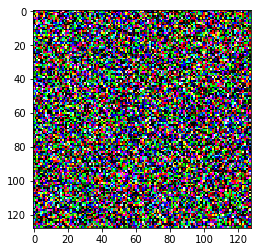

In [3]:
cycleGAN = CycleGAN()
#model = cycleGAN.generator()
model = cycleGAN.discriminator()

model.compile(optimizer='adam', loss='mse')
model.fit(x_train, y_train)

